In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')

device: cuda:0


In [18]:
class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers = 4, neurons = 100):
        super(FCN, self).__init__()
        layers = [nn.Linear(in_dim, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons, neurons), nn.Tanh()]
        layers.append(nn.Linear(neurons, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)
    
net = FCN(in_dim = 2, out_dim = 4).to(device)

In [19]:
def generate_collocation_points(N):
    x = torch.rand(N,1)
    y = torch.rand(N,1)

    X = torch.cat([x,y], dim = 1)
    return X

N_f = 10000

X_f = generate_collocation_points(N_f).to(device).requires_grad_(True)

In [21]:
def generate_boundary_points(N):
    x_l = torch.zeros(N,1) ; x_r = torch.ones(N,1); ylr = torch.rand(N,1)
    b_l = torch.cat([x_l,ylr], dim = 1); b_r = torch.cat([x_r,ylr], dim = 1)

    y_b = torch.zeros(N,1); y_t = torch.ones(N,1); xbt = torch.rand(N,1)
    b_b = torch.cat([xbt,y_b], dim = 1); b_t = torch.cat([xbt,y_t], dim = 1)

    b = torch.cat([b_l,b_r,b_b,b_t], dim = 0)

    return b

N_b = 2000

X_b = generate_boundary_points(N_b).to(device)

In [22]:
X_p = torch.tensor([[0.0,0.0]],dtype=torch.float32).to(device)

In [23]:
def compute_residuals():
    output = net(X_f)

    u = output[:,0:1]
    v = output[:,1:2]
    p = output[:,2:3]
    T = output[:,3:4]

    grads_u = autograd.grad(u, X_f, grad_outputs=torch.ones_like(u),create_graph= True )[0]

    u_x = grads_u[:,0:1]
    u_y = grads_u[:,1:2]

    u_x_x = autograd.grad(u_x, X_f, grad_outputs=torch.ones_like(u_x),create_graph= True )[0][:,0:1]
    u_y_y = autograd.grad(u_y, X_f, grad_outputs=torch.ones_like(u_y),create_graph= True )[0][:,1:2]


    grads_v = autograd.grad(v, X_f, grad_outputs=torch.ones_like(v),create_graph= True )[0]

    v_x = grads_v[:,0:1]
    v_y = grads_v[:,1:2]

    v_x_x = autograd.grad(v_x, X_f, grad_outputs=torch.ones_like(v_x),create_graph= True )[0][:,0:1]
    v_y_y = autograd.grad(v_y, X_f, grad_outputs=torch.ones_like(v_y),create_graph= True )[0][:,1:2]


    grads_T = autograd.grad(T, X_f, grad_outputs=torch.ones_like(T),create_graph= True )[0]

    T_x = grads_T[:,0:1]
    T_y = grads_T[:,1:2]

    T_x_x = autograd.grad(T_x, X_f, grad_outputs=torch.ones_like(T_x),create_graph= True )[0][:,0:1]
    T_y_y = autograd.grad(T_y, X_f, grad_outputs=torch.ones_like(T_y),create_graph= True )[0][:,1:2]


    grads_p = autograd.grad(p, X_f, grad_outputs=torch.ones_like(p),create_graph= True )[0]

    p_x = grads_p[:,0:1]
    p_y = grads_p[:,1:2]

    nu = 1.00/400
    alpha = 0.01
    



    res_u = u * u_x + v * u_y + p_x - nu * (u_x_x + u_y_y)
    res_v = u * v_x + v * v_y + p_y - nu * (v_x_x + v_y_y)
    res_c = u_x + v_y
    res_T = u * T_x + v * T_y - alpha * (T_x_x + T_y_y)


    return res_u, res_v, res_c, res_T


In [24]:
def boundary_loss():
    boundary_output = net(X_b)

    boundary_u = boundary_output[:,0:1]
    boundary_v = boundary_output[:,1:2]
    boundary_p = boundary_output[:,2:3]
    boundary_T = boundary_output[:,3:4]

    lid_points = (X_b[:,1] == 1).unsqueeze(1)

    wall_points = (X_b[:,1] != 1).unsqueeze(1)

    # Boundary conditions on walls, excluding the lid: u = v = 0, T = 0
    loss_wall = torch.mean((boundary_u[wall_points]) ** 2) + torch.mean((boundary_v[wall_points]) ** 2) + torch.mean((boundary_T[wall_points]) ** 2)

    # Boundary conditions on lid. u = 1, v = 0, T = 1
    loss_lid = torch.mean((boundary_u[lid_points] - 1.00) ** 2) + torch.mean((boundary_v[lid_points]) ** 2) + torch.mean((boundary_T[lid_points] - 1.00) ** 2)

    p_pred = net(X_p)[:,2:3]
    loss_p = torch.mean((p_pred) ** 2)


    return loss_wall, loss_lid, loss_p
    

In [25]:
def compute_losses():
    # Compute individual residuals
    res_u, res_v, res_c, res_T = compute_residuals()

    loss_u = torch.mean(res_u**2)
    loss_v = torch.mean(res_v**2)
    loss_T = torch.mean(res_T**2)
    loss_continuity = torch.mean(res_c**2)

    loss_wall, loss_lid, loss_p = boundary_loss()

    loss_int = loss_u + loss_v + loss_T + loss_continuity
    loss_bc = loss_wall + loss_lid

    total_loss = loss_int + loss_bc + loss_p

    return loss_u, loss_v, loss_T, loss_continuity, loss_bc, loss_p, total_loss

In [26]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

In [30]:
num_epochs = 10000

loss_u_list, loss_v_list, loss_T_list, loss_continuity_list, loss_bc_list, loss_p_list, total_loss_list = [],[],[],[],[],[],[]


for epoch in range(num_epochs):
    optimizer.zero_grad()

    loss_u, loss_v, loss_T, loss_continuity, loss_bc, loss_p, total_loss = compute_losses()

    loss_u.backward(retain_graph=True)
    loss_v.backward(retain_graph=True)
    loss_T.backward(retain_graph=True)
    loss_continuity.backward(retain_graph=True)
    loss_bc.backward(retain_graph=True)
    loss_p.backward()

    optimizer.step()

    loss_u_list.append(loss_u.item()); loss_v_list.append(loss_v.item()); loss_T_list.append(loss_T.item()), loss_continuity_list.append(loss_continuity.item())
    loss_bc_list.append(loss_bc.item()); loss_p_list.append(loss_p.item())
    total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss_u={loss_u.item():.3e}, loss_v={loss_v.item():.3e}, loss_T={loss_T.item():.3e},  loss_bc={loss_bc.item():.3e}, loss_p={loss_p.item():.3e} total={total_loss.item():.3e}")



Epoch 0: loss_u=1.306e-03, loss_v=5.135e-04, loss_T=8.776e-04,  loss_bc=1.312e-02, loss_p=2.438e-06 total=1.607e-02
Epoch 500: loss_u=8.253e-04, loss_v=4.949e-04, loss_T=1.062e-03,  loss_bc=1.337e-02, loss_p=1.846e-06 total=1.615e-02
Epoch 1000: loss_u=4.866e-04, loss_v=4.778e-04, loss_T=4.873e-04,  loss_bc=1.198e-02, loss_p=2.284e-06 total=1.372e-02
Epoch 1500: loss_u=3.932e-04, loss_v=4.824e-04, loss_T=6.271e-04,  loss_bc=1.157e-02, loss_p=3.818e-06 total=1.371e-02
Epoch 2000: loss_u=4.801e-04, loss_v=5.099e-04, loss_T=4.269e-04,  loss_bc=1.156e-02, loss_p=7.670e-06 total=1.324e-02
Epoch 2500: loss_u=4.939e-04, loss_v=4.523e-04, loss_T=6.661e-04,  loss_bc=1.125e-02, loss_p=8.903e-08 total=1.318e-02
Epoch 3000: loss_u=3.593e-04, loss_v=4.437e-04, loss_T=4.623e-04,  loss_bc=1.025e-02, loss_p=7.491e-07 total=1.215e-02
Epoch 3500: loss_u=5.302e-04, loss_v=4.430e-04, loss_T=3.242e-04,  loss_bc=9.959e-03, loss_p=4.702e-08 total=1.155e-02
Epoch 4000: loss_u=3.639e-04, loss_v=5.493e-04, loss

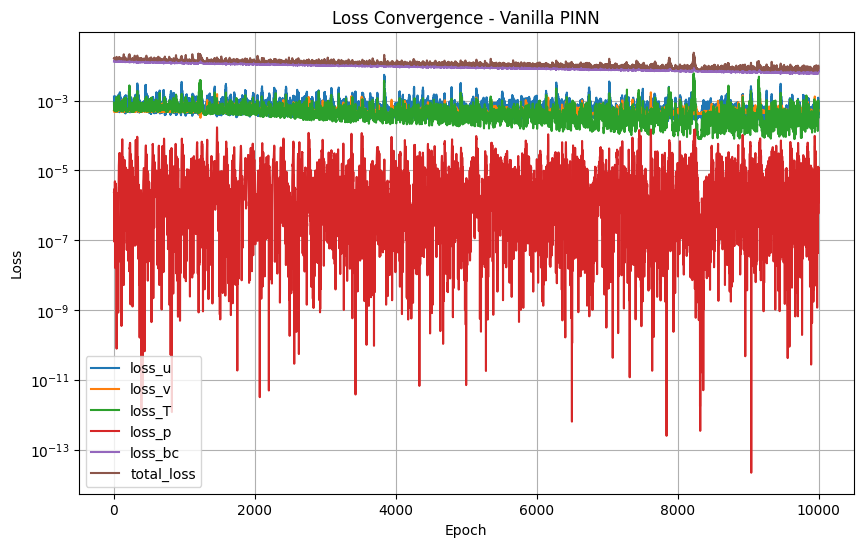

In [37]:
plt.figure(figsize=(10,6))
plt.plot(loss_u_list, label='loss_u')
plt.plot(loss_v_list, label='loss_v')
plt.plot(loss_T_list, label='loss_T')
plt.plot(loss_p_list, label='loss_p')
plt.plot(loss_bc_list, label='loss_bc')
plt.plot(total_loss_list, label='total_loss')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Convergence - Vanilla PINN'); plt.legend(); plt.grid(True)
plt.show()

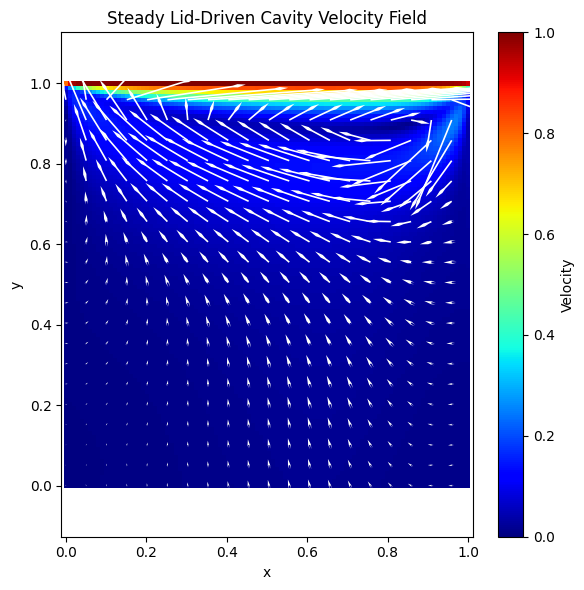

In [32]:
# Visualization

x = np.linspace(0,1,100)     # 100 X 1
y = np.linspace(0,1,100)     # 100 X 1

X,Y = np.meshgrid(x,y)       # Both 100 X 100

XY = np.stack([X.ravel(), Y.ravel()], axis = 1)    # 10000 X 2

net.eval()

with torch.no_grad():
    inp = torch.tensor(XY, dtype = torch.float32, device = device)
    output = net(inp).cpu().numpy()       # 10000 X 4 (u,v,p,t)

U = output[:, 0:1].reshape(100,100)   # 100 X 100
V = output[:,1:2].reshape(100,100)

speed = np.sqrt(U**2 + V**2)


plt.figure(figsize = (6,6))
pc = plt.pcolormesh(X,Y,speed, cmap = 'jet', shading = 'auto', vmin = 0, vmax = 1)
plt.colorbar(pc, label = 'Velocity')

dx = slice(None, None, 5)
dy = slice(None, None, 5)

plt.quiver(X[dx,dy], Y[dx,dy], U[dx,dy], V[dx,dy], color='white', scale_units='xy', scale=1,
    width=0.004, headwidth=2, headlength=5, headaxislength=8, minlength=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Steady Lid-Driven Cavity Velocity Field')
plt.axis('equal')
plt.tight_layout()
plt.show()